In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchinfo import summary
import re
import random

In [2]:
sentiment_dataset = pd.read_csv("Sentiment140_filtered.csv")

In [3]:
sentiment_dataset.head()

,Unnamed: 0,target,ids,date,flag,user,text,hate_pred
0,750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...,1
1,766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...,1
2,285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...,1
3,705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick",1
4,379611,0,2052381070,Sat Jun 06 00:32:23 PDT 2009,NO_QUERY,Portablemonkey,Tried to purchase a parked domain through GoDa...,1


In [4]:
sentiment_dataset.isnull().sum()

Unnamed: 0    0
target        0
ids           0
date          0
flag          0
user          0
text          0
hate_pred     0
dtype: int64

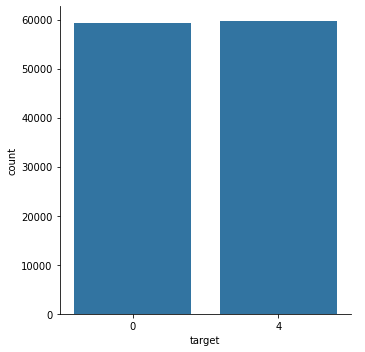

In [5]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')


In [6]:
hateful_dataset = pd.read_csv("hateful_sentiment.csv")

In [7]:
hateful_dataset.head()

,Content,Label,Content_int
0,retweet to the rejects who constantly call my ...,1,"[146715, 1761, 7, 3, 22587, 67, 6768, 472, 129..."
1,i purpose that whatever attack everyone who ca...,1,"[146715, 80, 4226, 28, 220, 1347, 1568, 67, 65..."
2,are you fucking kidding me you deserve to fuck...,1,"[146715, 154, 26, 69, 1361, 78, 26, 6610, 7, 6..."
3,retweet i am not racist and i am not sexist i ...,1,"[146715, 1761, 80, 81, 76, 1723, 111, 80, 81, ..."
4,just imagine if the two million spent on the s...,1,"[146715, 14, 925, 204, 3, 672, 462, 5271, 9, 3..."


In [8]:
hateful_dataset = hateful_dataset[["Content", "Label"]]
hateful_dataset = hateful_dataset.rename(columns = {"Content": "text", "Label": "target"})
hateful_dataset["target"] = 2

hateful_dataset.head()

,text,target
0,retweet to the rejects who constantly call my ...,2
1,i purpose that whatever attack everyone who ca...,2
2,are you fucking kidding me you deserve to fuck...,2
3,retweet i am not racist and i am not sexist i ...,2
4,just imagine if the two million spent on the s...,2


In [9]:
sentiment_dataset = sentiment_dataset[["text", "target"]]
sentiment_dataset.head()

,text,target
0,I'm off too bed. I gotta wake up hella early t...,0
1,I havent been able to listen to it yet My spe...,0
2,now remembers why solving a relatively big equ...,0
3,"Ate too much, feel sick",0
4,Tried to purchase a parked domain through GoDa...,0


In [10]:
sentiment_dataset.loc[sentiment_dataset['target']==4, 'target'] = 1
sentiment_dataset.loc[sentiment_dataset['target']==0, 'target'] = 0
# 0 - negative, 1 - positive, 2 - hateful

In [11]:
sentiment_dataset = pd.concat([sentiment_dataset, hateful_dataset], ignore_index= True)

In [12]:
sentiment_dataset.head()

,text,target
0,I'm off too bed. I gotta wake up hella early t...,0
1,I havent been able to listen to it yet My spe...,0
2,now remembers why solving a relatively big equ...,0
3,"Ate too much, feel sick",0
4,Tried to purchase a parked domain through GoDa...,0


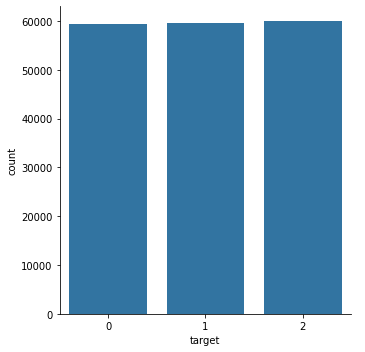

In [13]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')

In [14]:
sentiment_dataset['target'].value_counts()

target
2    60000
1    59700
0    59300
Name: count, dtype: int64

In [15]:
sentiment_dataset.isnull().sum()

text      0
target    0
dtype: int64

In [16]:
X = sentiment_dataset['text']
y = sentiment_dataset['target']

In [17]:
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

CNN

In [18]:
# Tokenizacja i czyszczenie tekstu
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.split() # podział na tokeny (słowa) po spacjach

# Tworzenie słownika
all_tokens = [token for text in sentiment_dataset['text'] for token in tokenize(text)]
vocab = {word: i+2 for i, (word, _) in enumerate(Counter(all_tokens).most_common(10000))}
vocab['<PAD>'] = 0 # do wyrównania długości sekwencji
vocab['<UNK>'] = 1 # dla słów nieznanych

# tokenizacja tekstu, zamiana słów na indeksy słownika, jeśli nie ma słowa w słowniku -> wartość 1
def encode(text):
    return [vocab.get(token, 1) for token in tokenize(text)]

In [19]:
# Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(encode(text)) for text in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Funkcja padding collate
def collate_fn(batch):
    texts, labels = zip(*batch) # rozdzielenie par na 2 listy
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0) # wyrównanie długości sekwencji
    return texts_padded, torch.tensor(labels)

In [20]:
# Model CNN
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0) # zmiana indeksów słów w wektory
        self.conv1 = nn.Conv1d(embed_dim, 100, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.embedding(x) 
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.dropout(x) 
        x = self.pool(x).squeeze(2)
        return self.fc(x)
    

In [29]:
# Hiperparametry
epochs_num = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextCNN(vocab_size=len(vocab), embed_dim=100, num_classes=3).to(device)
embed_dim = 100

param_grid = list(ParameterGrid({
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],
    'batch': [32, 64, 128]
}))

In [30]:
# Podsumowanie modelu
summary(model, input_size=(32, 100), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
TextCNN                                  [32, 3]                   --
├─Embedding: 1-1                         [32, 100, 100]            1,000,200
├─Conv1d: 1-2                            [32, 100, 98]             30,100
├─ReLU: 1-3                              [32, 100, 98]             --
├─Dropout: 1-4                           [32, 100, 98]             --
├─AdaptiveMaxPool1d: 1-5                 [32, 100, 1]              --
├─Linear: 1-6                            [32, 3]                   303
Total params: 1,030,603
Trainable params: 1,030,603
Non-trainable params: 0
Total mult-adds (M): 126.41
Input size (MB): 0.03
Forward/backward pass size (MB): 5.07
Params size (MB): 4.12
Estimated Total Size (MB): 9.22

In [31]:
# Podział na 5 foldów
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

def evaluate_model(model, val_loader):
    model.eval()  # Ustawienie modelu w tryb ewaluacji
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():  # Bez obliczania gradientów
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    
    return true_labels, pred_labels

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs_num):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct_preds / total_preds
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [32]:
results = []
best_f1 = 0.0
best_cm = None

for param_idx, params in enumerate(param_grid):
    lr = params['learning_rate']
    batch = params['batch']
    print(f"\n=== Param set {param_idx+1}/{len(param_grid)}: LR={lr}, Batch={batch} ===")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"\nTraining fold {fold+1}/5...")

        train_texts, val_texts = X.iloc[train_idx], X.iloc[val_idx]
        train_labels, val_labels = y.iloc[train_idx], y.iloc[val_idx]

        train_dataset = TextDataset(train_texts.tolist(), train_labels.tolist())
        val_dataset = TextDataset(val_texts.tolist(), val_labels.tolist())

        train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False, collate_fn=collate_fn)

        model = TextCNN(vocab_size=len(vocab), embed_dim=embed_dim, num_classes=3).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        model, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(
            model, train_loader, val_loader, criterion, optimizer, epochs=epochs_num
        )

        true_labels, pred_labels = evaluate_model(model, val_loader)

        accuracy = accuracy_score(true_labels, pred_labels)
        precision = precision_score(true_labels, pred_labels, average='weighted')
        recall = recall_score(true_labels, pred_labels, average='weighted')
        f1 = f1_score(true_labels, pred_labels, average='weighted')
        cm = confusion_matrix(true_labels, pred_labels)

        results.append({
            "params_id": param_idx + 1,
            "fold": fold + 1,
            "learning_rate": lr,
            "batch": batch,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_matrix": cm
        })

        if f1 > best_f1:
            best_f1 = f1
            best_cm = cm
            torch.save(model.state_dict(), f"best_model_paramset_{param_idx+1}_fold_{fold+1}.pth")



=== Param set 1/12: LR=1e-05, Batch=32 ===

Training fold 1/5...
Epoch 1/4 - Train Loss: 1.0154 - Val Loss: 0.9604 - Train Acc: 0.4822 - Val Acc: 0.5641
Epoch 2/4 - Train Loss: 0.8988 - Val Loss: 0.8911 - Train Acc: 0.5676 - Val Acc: 0.6155
Epoch 3/4 - Train Loss: 0.8350 - Val Loss: 0.8447 - Train Acc: 0.6062 - Val Acc: 0.6412
Epoch 4/4 - Train Loss: 0.7921 - Val Loss: 0.8092 - Train Acc: 0.6286 - Val Acc: 0.6608

Training fold 2/5...
Epoch 1/4 - Train Loss: 1.0212 - Val Loss: 0.9625 - Train Acc: 0.4770 - Val Acc: 0.5628
Epoch 2/4 - Train Loss: 0.8976 - Val Loss: 0.8938 - Train Acc: 0.5701 - Val Acc: 0.6097
Epoch 3/4 - Train Loss: 0.8351 - Val Loss: 0.8479 - Train Acc: 0.6072 - Val Acc: 0.6408
Epoch 4/4 - Train Loss: 0.7918 - Val Loss: 0.8125 - Train Acc: 0.6309 - Val Acc: 0.6601

Training fold 3/5...
Epoch 1/4 - Train Loss: 1.0233 - Val Loss: 0.9541 - Train Acc: 0.4698 - Val Acc: 0.5732
Epoch 2/4 - Train Loss: 0.8801 - Val Loss: 0.8775 - Train Acc: 0.5788 - Val Acc: 0.6168
Epoch 3/4 

In [36]:
import pandas as pd

# Konwersja listy wyników do DataFrame
df_results = pd.DataFrame(results)

# Zapis do pliku CSV
df_results.to_csv("results_grid_search.csv", index=False)

In [37]:
print(df_results)

    params_id  fold  learning_rate  batch  accuracy  precision    recall  \
0           1     1        0.00001     32  0.660754   0.654787  0.660754   
1           1     2        0.00001     32  0.660056   0.654430  0.660056   
2           1     3        0.00001     32  0.661676   0.655392  0.661676   
3           1     4        0.00001     32  0.660112   0.654662  0.660112   
4           1     5        0.00001     32  0.660726   0.653849  0.660726   
5           2     1        0.00010     32  0.783883   0.780828  0.783883   
6           2     2        0.00010     32  0.781704   0.778885  0.781704   
7           2     3        0.00010     32  0.781369   0.778414  0.781369   
8           2     4        0.00010     32  0.781927   0.778640  0.781927   
9           2     5        0.00010     32  0.785922   0.782795  0.785922   
10          3     1        0.00100     32  0.828687   0.826740  0.828687   
11          3     2        0.00100     32  0.826425   0.824853  0.826425   
12          

In [38]:
# Zakładam, że Twój DataFrame nazywa się df_results
best_per_param = df_results.loc[df_results.groupby("params_id")["f1"].idxmax()].reset_index(drop=True)
print(best_per_param)

best_per_param.to_csv("results_grid_search_best.csv", index=False)

    params_id  fold  learning_rate  batch  accuracy  precision    recall  \
0           1     3        0.00001     32  0.661676   0.655392  0.661676   
1           2     5        0.00010     32  0.785922   0.782795  0.785922   
2           3     3        0.00100     32  0.828212   0.829807  0.828212   
3           4     4        0.01000     32  0.785112   0.786984  0.785112   
4           5     1        0.00001     64  0.641676   0.636029  0.641676   
5           6     5        0.00010     64  0.771006   0.767664  0.771006   
6           7     1        0.00100     64  0.832039   0.831072  0.832039   
7           8     4        0.01000     64  0.801285   0.806215  0.801285   
8           9     3        0.00001    128  0.616369   0.609975  0.616369   
9          10     4        0.00010    128  0.755531   0.752380  0.755531   
10         11     3        0.00100    128  0.826145   0.825625  0.826145   
11         12     1        0.01000    128  0.811341   0.814395  0.811341   

          f


===== ACCURACY =====

Średnie wyniki dla każdej konfiguracji:
params_id
7     0.8250
11    0.8235
3     0.8235
12    0.8072
8     0.7957
2     0.7830
6     0.7693
4     0.7628
10    0.7524
1     0.6607
5     0.6367
9     0.6104
dtype: float64

Friedman test stat=53.7077, p=0.0000
Istnieje istotna różnica między konfiguracjami. Przeprowadzam test Nemenyiego...


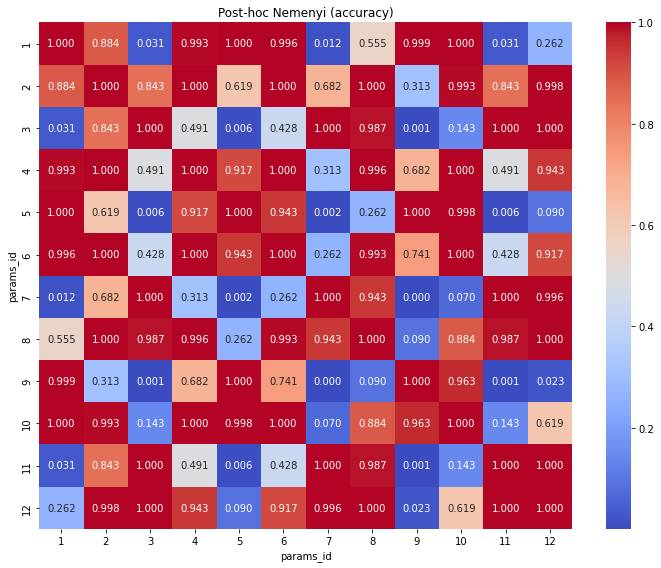


===== PRECISION =====

Średnie wyniki dla każdej konfiguracji:
params_id
3     0.8254
7     0.8252
11    0.8232
12    0.8115
8     0.8007
4     0.7840
2     0.7799
6     0.7662
10    0.7488
1     0.6546
5     0.6305
9     0.6036
dtype: float64

Friedman test stat=54.2308, p=0.0000
Istnieje istotna różnica między konfiguracjami. Przeprowadzam test Nemenyiego...


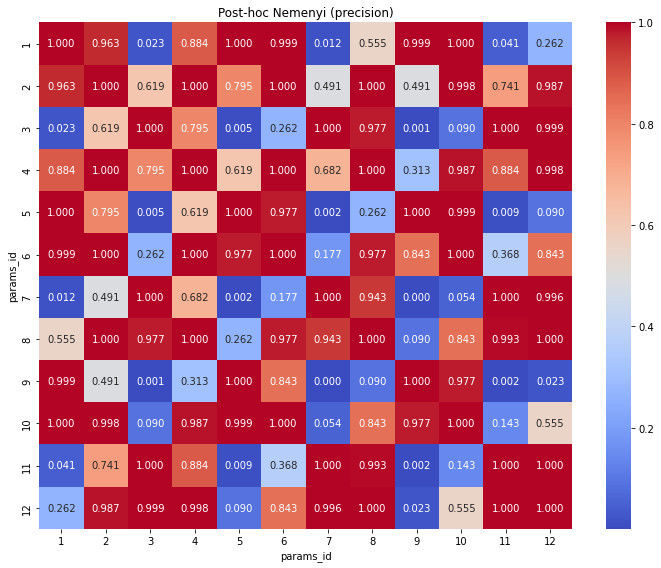


===== RECALL =====

Średnie wyniki dla każdej konfiguracji:
params_id
7     0.8250
11    0.8235
3     0.8235
12    0.8072
8     0.7957
2     0.7830
6     0.7693
4     0.7628
10    0.7524
1     0.6607
5     0.6367
9     0.6104
dtype: float64

Friedman test stat=53.7077, p=0.0000
Istnieje istotna różnica między konfiguracjami. Przeprowadzam test Nemenyiego...


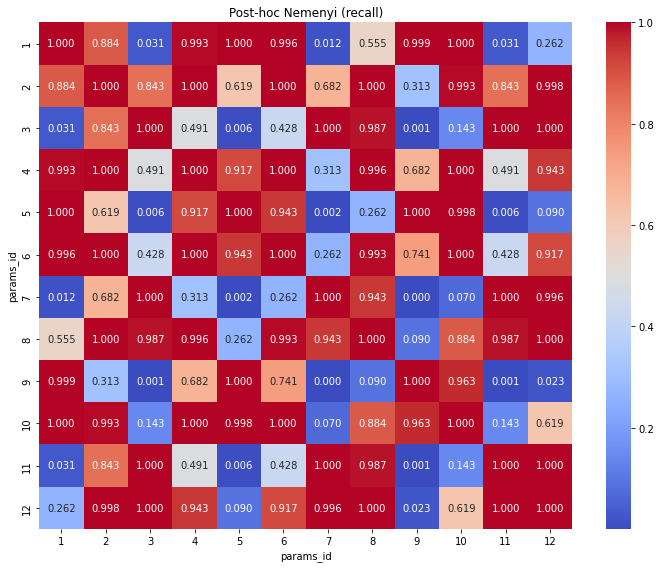

In [40]:
import pandas as pd
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pyplot as plt

# Zakładamy, że Twój DataFrame to `df`

# Lista metryk do analizy
metrics = ['accuracy', 'precision', 'recall']

for metric in metrics:
    print(f"\n===== {metric.upper()} =====")

    # Tworzymy pivot: fold jako wiersze, params_id jako kolumny
    pivot = df_results.pivot(index='fold', columns='params_id', values=metric)

    # Sprawdzenie braków
    if pivot.isnull().values.any():
        print("⚠️ Braki danych. Nie można przeprowadzić testu.")
        continue

    # Wyświetl średnie wyniki
    print("\nŚrednie wyniki dla każdej konfiguracji:")
    print(pivot.mean().sort_values(ascending=False).round(4))

    # Test Friedmana
    stat, p = friedmanchisquare(*[pivot[col] for col in pivot.columns])
    print(f"\nFriedman test stat={stat:.4f}, p={p:.4f}")

    if p < 0.05:
        print("Istnieje istotna różnica między konfiguracjami. Przeprowadzam test Nemenyiego...")

        # Test Nemenyiego
        nemenyi = sp.posthoc_nemenyi_friedman(pivot)

        # Rysujemy heatmapę post-hoc
        plt.figure(figsize=(10, 8))
        sns.heatmap(nemenyi, annot=True, cmap="coolwarm", fmt=".3f", xticklabels=True, yticklabels=True)
        plt.title(f"Post-hoc Nemenyi ({metric})")
        plt.xlabel("params_id")
        plt.ylabel("params_id")
        plt.tight_layout()
        plt.show()

    else:
        print("Brak istotnych różnic między konfiguracjami.")
